In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import os
import glob
from sklearn.tree import DecisionTreeRegressor
import csv
from datetime import datetime

In [ ]:
from sqlalchemy import create_engine
from dotenv import load_dotenv
import logging
from datetime import datetime

# Cargar variables de entorno
load_dotenv()
db_user = os.getenv("DB_USER")
db_password = os.getenv("DB_PASSWORD")
db_host = os.getenv("DB_HOST")
db_port = os.getenv("DB_PORT")
db_name = os.getenv("DB_NAME")

import pandas as pd

# Conexión a la base de datos PostgreSQL
engine = create_engine(f"postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}")

# Consulta a la base de datos para obtener los datos del transformador
query = "SELECT * FROM transformer_table;"
df_base = pd.read_sql_query(query, engine)

df_base.head()


,Timestamp,temperatura_ambiente,temperatura_burbujeo,temperatura_punto_caliente,corriente_carga,humedad_papel_aislante,temperatura_aceite_OLTC,potencia_aparente,posicion_tap,temperatura_aceite,voltage
0,2024-09-10 04:00:00,26.500000,178.928398,58.642727,733.840371,0.587974,51.025001,30.489245,11.0,53.500,130.845832
1,2024-09-10 04:30:00,26.733334,178.534617,57.973421,708.433386,0.597363,50.700001,29.445180,11.0,53.225,130.877445
2,2024-09-10 05:00:00,26.316667,176.250397,57.304115,684.065427,0.610628,50.375001,28.426628,11.0,52.950,130.744998
3,2024-09-10 05:30:00,25.900000,176.001775,57.072746,667.426629,0.623892,50.050001,27.773739,11.0,52.675,131.075749
4,2024-09-10 06:00:00,26.000000,175.753153,56.585251,651.429854,0.637156,49.725001,27.144727,11.0,52.400,131.231456


In [94]:
df_base['Timestamp'] = pd.to_datetime(df_base['Timestamp'])
df_base.set_index('Timestamp', inplace=True)
print(df_base.shape)

(12126, 10)


In [95]:
print(df_base.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12126 entries, 2024-09-10 04:00:00 to 2025-05-31 00:00:00
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   temperatura_ambiente        12126 non-null  float64
 1   temperatura_burbujeo        12126 non-null  float64
 2   temperatura_punto_caliente  12126 non-null  float64
 3   corriente_carga             12126 non-null  float64
 4   humedad_papel_aislante      12126 non-null  float64
 5   temperatura_aceite_OLTC     12126 non-null  float64
 6   potencia_aparente           12126 non-null  float64
 7   posicion_tap                12126 non-null  float64
 8   temperatura_aceite          12126 non-null  float64
 9   voltage                     12126 non-null  float64
dtypes: float64(10)
memory usage: 1.0 MB
None


In [96]:
df_base.describe()


,temperatura_ambiente,temperatura_burbujeo,temperatura_punto_caliente,corriente_carga,humedad_papel_aislante,temperatura_aceite_OLTC,potencia_aparente,posicion_tap,temperatura_aceite,voltage
count,12126.000000,12126.000000,12126.000000,12126.000000,12126.000000,12126.000000,12126.000000,12126.000000,12126.000000,12126.000000
mean,26.221320,173.425133,53.842404,763.791925,0.742715,44.039485,30.725135,8.946873,48.508658,130.278939
std,5.623848,6.750201,7.888142,178.529353,0.179874,6.256350,7.187382,1.687362,6.189006,2.321152
min,7.100000,156.015203,36.335445,337.367235,0.351356,29.100000,7.051702,1.000000,32.799999,124.003937
25%,22.200000,169.005573,47.928926,633.493459,0.607285,39.500000,25.360600,7.937500,44.033333,128.689779
50%,26.099999,172.941307,53.268437,725.514910,0.719724,44.000000,29.173605,9.000000,48.533334,130.356886
75%,30.093750,176.565750,59.446581,879.936081,0.857828,48.500000,35.441545,10.000000,52.850000,131.942173
max,40.633333,193.934830,78.077015,1264.957637,1.328628,61.900002,50.999246,17.000000,66.500000,136.928979


In [ ]:
#Analisis
"""
Resumen del análisis:
si std es cero, significa que los datos son constantes y no hay variabilidad.
Si la media es cero, significa que los datos están centrados en cero.


"""

In [97]:
'''
No se encontraron valores nulos ni duplicados en el DataFrame. Dataset limpio y listo para el análisis.
'''
# Detección de valores nulos
missing_values = df_base.isnull().sum()
# Detección de valores duplicados
duplicated_rows = df_base.duplicated().sum()
print("Valores nulos:")
print(missing_values)
print("Registros duplicados:")
print(duplicated_rows)


Valores nulos:
temperatura_ambiente          0
temperatura_burbujeo          0
temperatura_punto_caliente    0
corriente_carga               0
humedad_papel_aislante        0
temperatura_aceite_OLTC       0
potencia_aparente             0
posicion_tap                  0
temperatura_aceite            0
voltage                       0
dtype: int64
Registros duplicados:
0


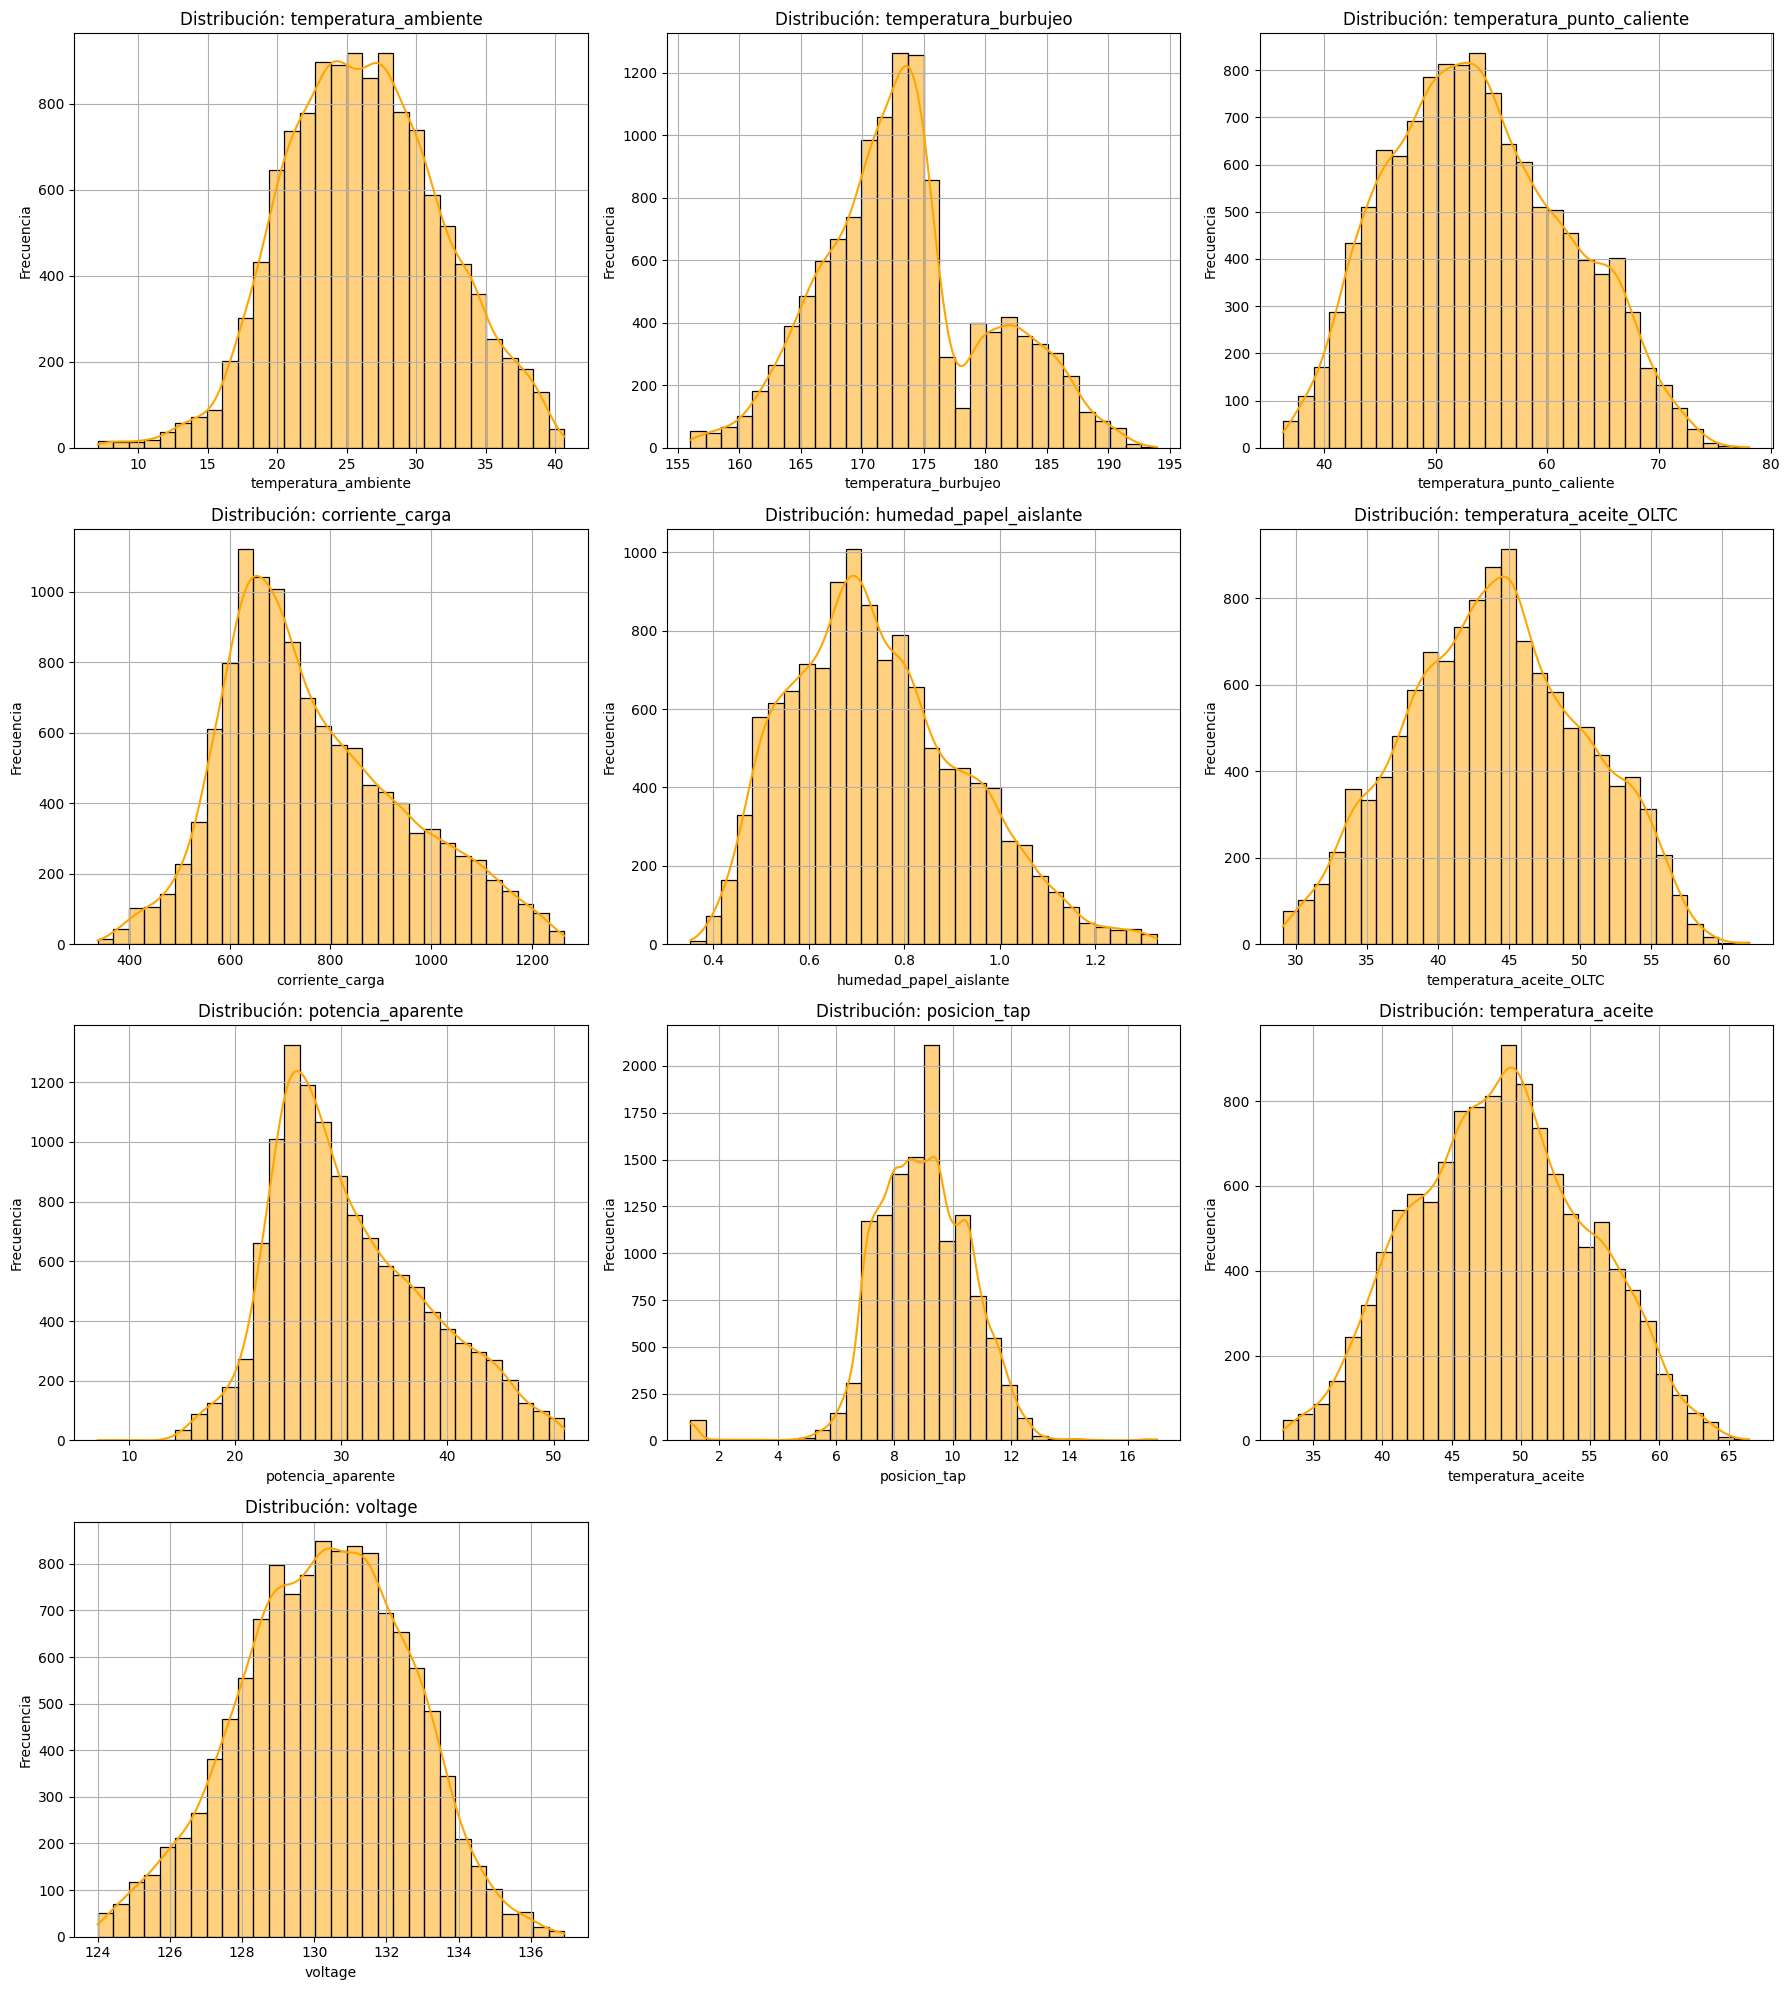

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_variable_distributions(df):
    """
    Función para graficar la distribución de todas las variables numéricas en el DataFrame.
     Analizar la forma de la distribución (¿es normal, sesgada, con outliers?).
     Detectar posibles valores extremos que puedan distorsionar el entrenamiento.
    """
    # Filtrar solo las columnas numéricas
    numeric_cols = df.select_dtypes(include='number').columns
    num_vars = len(numeric_cols)

    # Calcular número de filas necesarias
    n_cols = 3
    n_rows = int(np.ceil(num_vars / n_cols))

    # Crear figura y ejes
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
    axs = axs.flatten()  # Para indexar fácilmente

    for i, col in enumerate(numeric_cols):
        sns.histplot(df[col], bins=30, kde=True, edgecolor='black', color='orange', ax=axs[i])
        axs[i].set_title(f'Distribución: {col}')
        axs[i].set_xlabel(col)
        axs[i].set_ylabel('Frecuencia')
        axs[i].grid(True)

    # Si sobran subplots, ocultarlos
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()
# Llamar a la función para graficar las distribuciones
plot_variable_distributions(df_base)

In [ ]:
'''Análisis de estadísticos descriptivos
Temperatura ambiente: tiene uforma de campana moderadamente sesgada a la derecha, rango entre 7 y 40, en climas calidos contribuye mas al tranqsformador.
Temperatura Burbujeo: distribucion multimodal, dsitinta carga de operacion
Temperatura punto caliente (variable objetivo): una forma de campana, con ligera cola a la derecha, ideal para modelar con regresesión. 
Correinte carga: sesgada a la izquiera, podria requerir tranformacion logaritmica para estandarizar 
humedad papel aislante: ligero seso, distribucion relativamnete concentraad
temperatura oltc: ligeramente sesgada a la derecha, posible relacion directa con la temperatura del transformador
potencia aparente: sesgada a la derecha, refleja el nivel de carga y uso del trasnformador
position tap. distribucion discreta, cambios en la posicion del tap changer reflejan ajustes de voltaje como variables discrteas, la interprestacion debe ser cuidadosa
temperatura aceite: forma  de cmapana, probablemente relacionada con la temperatura del transformador
voltage: forma de campana
'''

In [99]:
def heatMap(df):
    plt.figure(figsize=(10,8))
    sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Matriz de correlación")
    plt.show()

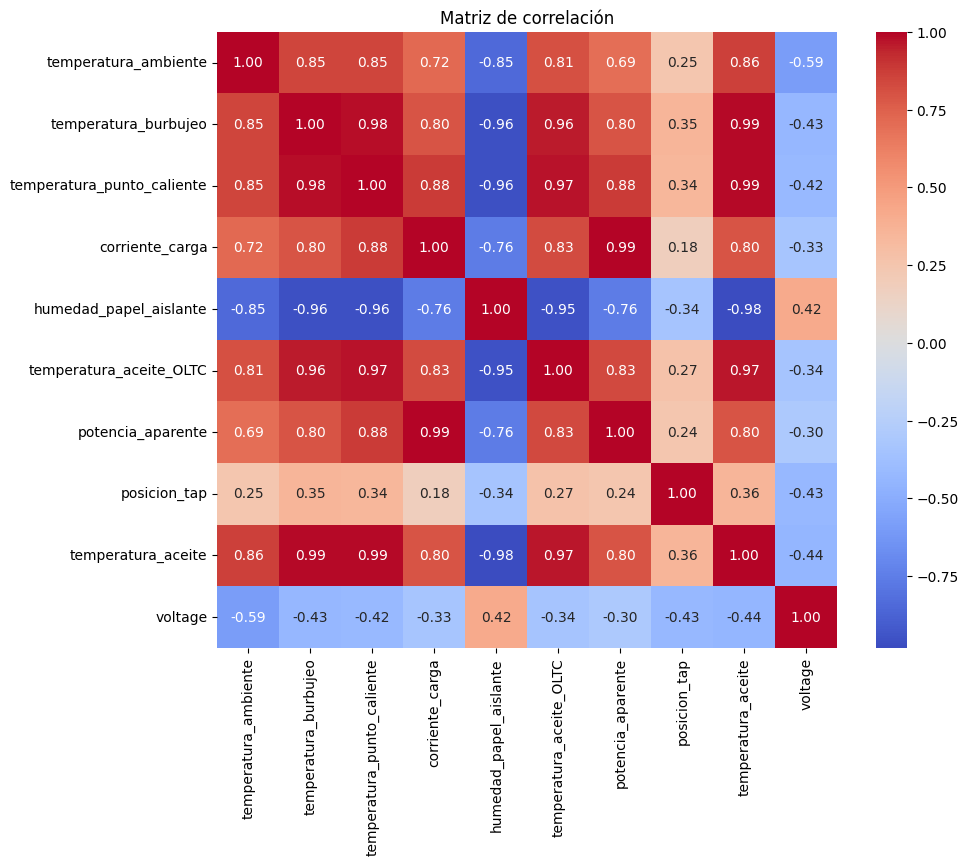

In [ ]:
'''
Qué variables tienen fuerte correlación con la variable objetivo.
Qué variables están correlacionadas entre sí.
El análisis de correlación nos ayudará a filtrar y priorizar las variables que realmente aportan valor.
1 temperatura_aceite: 0.99
2 temperatura_burbujeo: 0.98
3 temperatura_aceite_OLTC: 0.97
4 potencia_aparente: 0.88
5 corriente_carga: 0.88
6 temperatura_ambiente: 0.85
7 voltage 0.42
'''
heatMap(df_base)

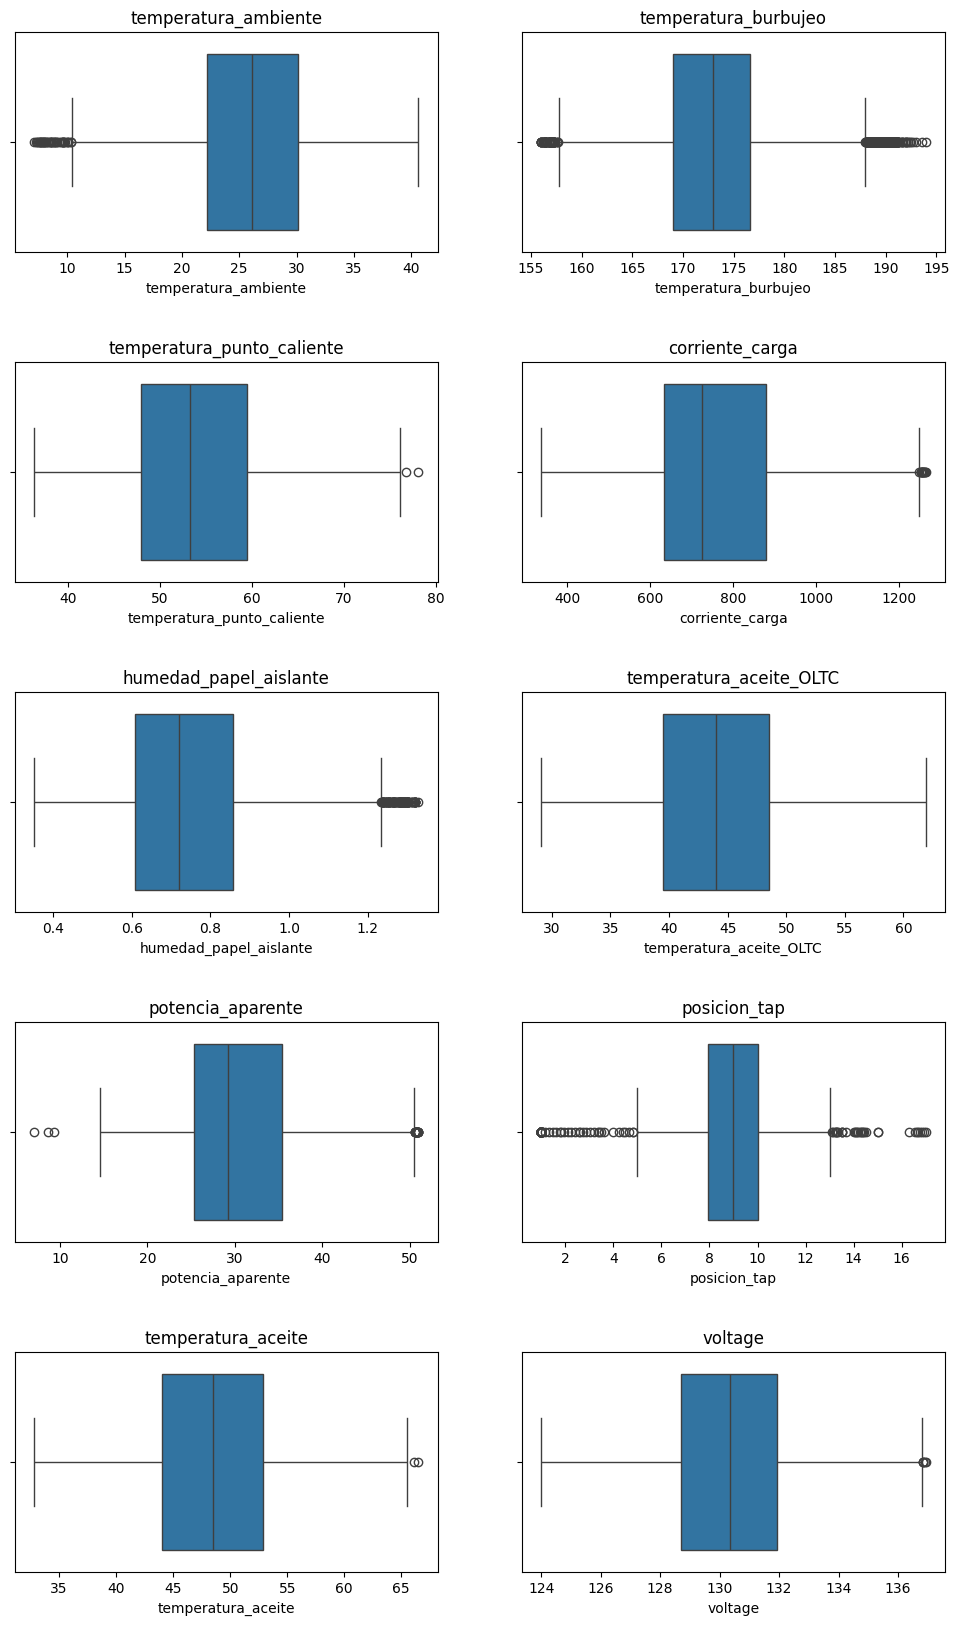

In [118]:
def boxplots(df):
    # Obtener las columnas numéricas
    cols_num = df.select_dtypes(include=['number']).columns.tolist()
    num_cols = 2  # Número de columnas en el subplot
    num_rows = (len(cols_num) + num_cols - 1) // num_cols

    # Crear subgráficos
    fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 4 * num_rows))
    fig.subplots_adjust(hspace=0.5)
    ax = ax.flatten()

    # Generar gráficos individuales
    for i, col in enumerate(cols_num):
        sns.boxplot(x=df[col], ax=ax[i])
        ax[i].set_title(col)

    # Ocultar subplots vacíos si hay un número impar de gráficos
    for j in range(i + 1, len(ax)):
        fig.delaxes(ax[j])

    plt.show()
boxplots(df_base)

In [102]:
def detect_outliers_iqr(df):
    """
    Detecta outliers usando el rango intercuartil (IQR) para cada variable numérica.
    Devuelve un DataFrame con la cantidad de outliers detectados por variable.
    """
    outliers_dict = {}
    numeric_cols = df.select_dtypes(include='number').columns

    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers_count = df[(df[col] < lower_bound) | (df[col] > upper_bound)].shape[0]
        outliers_dict[col] = outliers_count

    outliers_df = pd.DataFrame.from_dict(outliers_dict, orient='index', columns=['Outliers'])
    return outliers_df
detect_outliers_iqr(df_base)

,Outliers
temperatura_ambiente,43
temperatura_burbujeo,315
temperatura_punto_caliente,2
corriente_carga,13
humedad_papel_aislante,97
temperatura_aceite_OLTC,0
potencia_aparente,21
posicion_tap,167
temperatura_aceite,2
voltage,5


In [103]:

def timeplot(df, variable, titulo=None, ylabel=None):
    """
    Grafica una variable en el tiempo desde un DataFrame con índice datetime.

    Parámetros:
    - df: DataFrame con índice tipo Timestamp
    - variable: nombre de la columna a graficar (string)
    - titulo: (opcional) título del gráfico
    - ylabel: (opcional) etiqueta del eje Y
    """
    if variable not in df.columns:
        print(f"La variable '{variable}' no está en el DataFrame.")
        return

    plt.figure(figsize=(15, 5))
    plt.plot(df.index, df[variable], label=variable, color='tab:blue')
    plt.xlabel("Tiempo")
    plt.ylabel(ylabel if ylabel else variable)
    plt.title(titulo if titulo else f"Evolución temporal de {variable}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

timeplot(df_base, 'temperature_ambiente', titulo='Evolución de Temperatura Ambiente', ylabel='Temperatura Ambiente (°C)')
    


La variable 'temperature_ambiente' no está en el DataFrame.


In [119]:
def plot_all_scatter(df, y, exclude_cols=["Timestamp"]):
    """
    Genera scatter plots de todas las columnas numéricas en `df` contra `y`.

    Parámetros:
    - df (DataFrame): El DataFrame con los datos.
    - y (str): La variable dependiente.
    - exclude_cols (list): Columnas a excluir en el análisis.
    """
    # Seleccionar variables numéricas excepto las excluidas y la variable objetivo
    variables_x = [col for col in df.columns if col not in exclude_cols + [y] and df[col].dtype != 'O']

    if not variables_x:
        print("No hay variables numéricas para graficar.")
        return

    # Calcular número de filas de subplots
    filas = len(variables_x) // 2 + len(variables_x) % 2
    fig, axes = plt.subplots(filas, 2, figsize=(12, 4 * filas))
    axes = axes.flatten()

    for i, x in enumerate(variables_x):
        if df[[x, y]].dropna().empty:
            axes[i].text(0.5, 0.5, "Datos insuficientes", fontsize=12, ha='center', va='center')
            axes[i].set_title(f"{y} vs {x}")
            axes[i].axis("off")
            continue

        axes[i].scatter(df[x], df[y], alpha=0.5, edgecolors='k')
        axes[i].grid(True, linestyle="--", alpha=0.6)
        axes[i].set_title(f"{y} vs {x}")
        axes[i].set_xlabel(x)
        axes[i].set_ylabel(y)

    # Ocultar subplots vacíos
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()


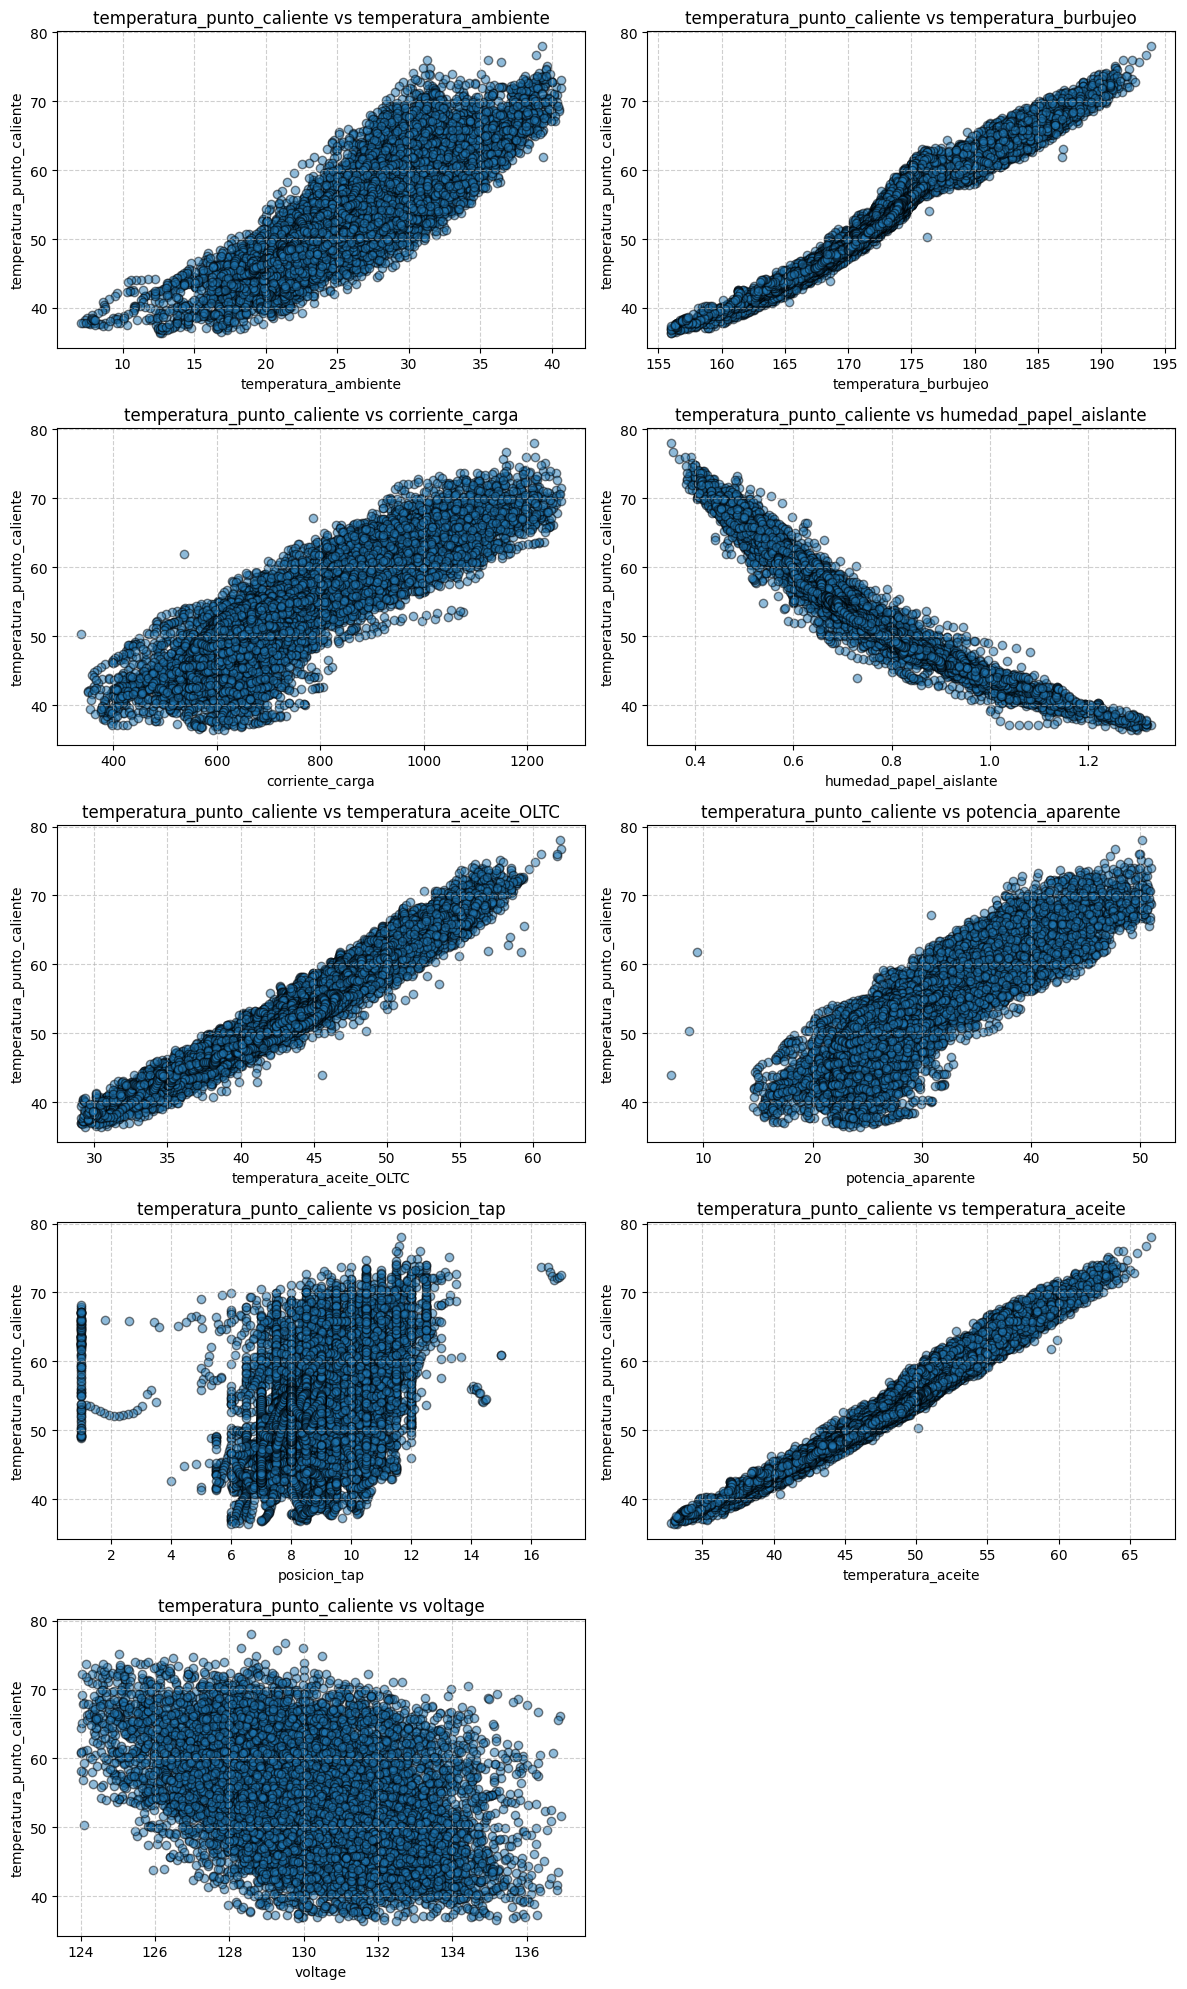

In [104]:

'''
tpc vs ta: A mayor temperatura ambiente, suele aumentar la temperatura en el punto caliente. Confirmamos que temperatura_ambiente es un buen feature para el modelo.
tpc vs tbur: A medida que sube la temperatura de burbujeo del aceite, también lo hace la temperatura en el punto caliente. Esto refuerza la elección de este feature.
tpc vs cc: A mayor corriente de carga, aumenta la temperatura en el punto caliente.
tpc vs hpa: A mayor humedad, menor temperatura en el punto caliente.Esto podría deberse a un efecto operacional o a que la humedad aumenta en condiciones de menor carga.



'''

plot_all_scatter(df_base, "temperatura_punto_caliente")

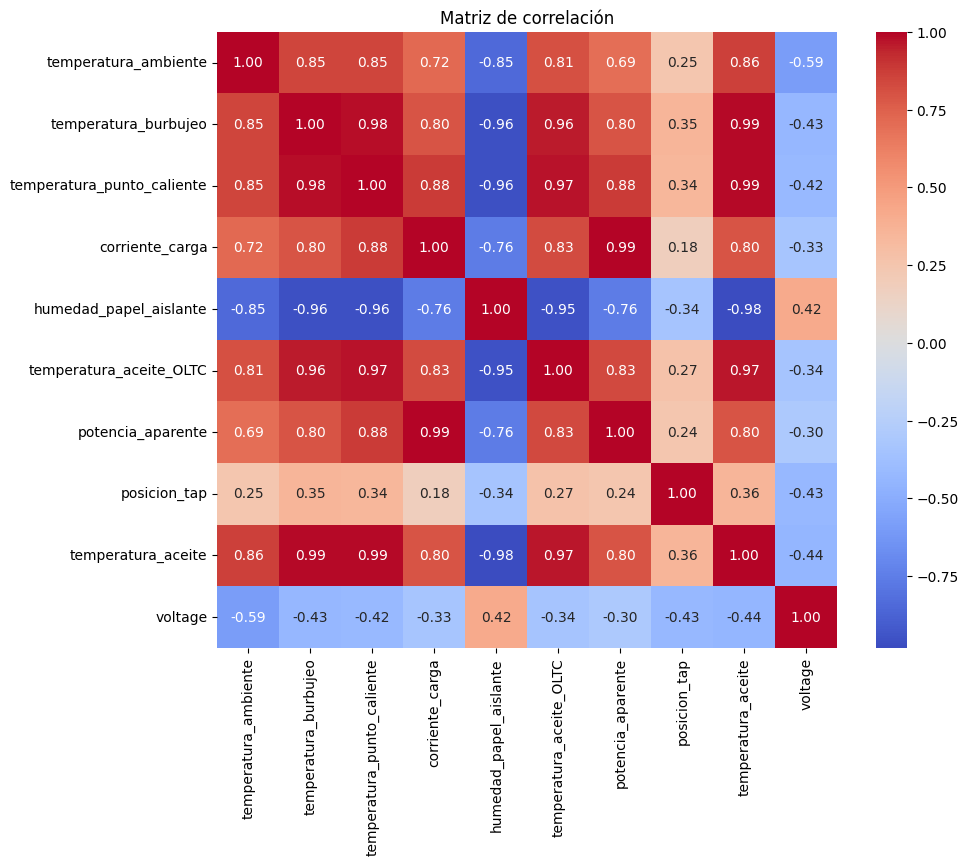

In [105]:
heatMap(df_base )

In [ ]:
#existe una alta correlacion de variables, por lo que se recomienda eliminar las variables con menor correlacion con la variable objetivo
#rango de umbral recomendado minimo 0.85, maximo 0

In [113]:
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

def prepare_features(df):
    """
    Selecciona las variables relevantes y aplica transformaciones logarítmicas a las variables sesgadas.
    Devuelve un DataFrame listo para modelar y la variable objetivo.
    """
    df_prepared = df.copy()

    # Transformaciones logarítmicas para variables sesgadas
    df_prepared['corriente_carga_log'] = np.log1p(df_prepared['corriente_carga'])
    df_prepared['potencia_aparente_log'] = np.log1p(df_prepared['potencia_aparente'])

    # Features seleccionadas
    features = [
        'temperatura_ambiente',
        'temperatura_burbujeo',
        'temperatura_aceite',
        'voltage',
        'temperatura_aceite_OLTC',
        'humedad_papel_aislante',
        'posicion_tap',
        'corriente_carga_log',
        'potencia_aparente_log',
    ]

    # Variables de entrada (X) y objetivo (y)
    X = df_prepared[features]
    y = df_prepared['temperatura_punto_caliente']

    return X, y

X, y = prepare_features(df_base)

In [120]:
print ("Variables de entrada (X):")
X.head()

Variables de entrada (X):


,temperatura_ambiente,temperatura_burbujeo,temperatura_aceite,voltage,temperatura_aceite_OLTC,humedad_papel_aislante,posicion_tap,corriente_carga_log,potencia_aparente_log
0,26.500000,178.928398,53.500,130.845832,51.025001,0.587974,11.0,6.599653,3.449646
1,26.733334,178.534617,53.225,130.877445,50.700001,0.597363,11.0,6.564467,3.415928
2,26.316667,176.250397,52.950,130.744998,50.375001,0.610628,11.0,6.529514,3.381900
3,25.900000,176.001775,52.675,131.075749,50.050001,0.623892,11.0,6.504927,3.359463
4,26.000000,175.753153,52.400,131.231456,49.725001,0.637156,11.0,6.480704,3.337360


In [121]:
print("\nVariable objetivo (y):")
y.head()


Variable objetivo (y):


0    58.642727
1    57.973421
2    57.304115
3    57.072746
4    56.585251
Name: temperatura_punto_caliente, dtype: float64

In [122]:
# División temporal 80% train - 20% test
split_index = int(len(df_base) * 0.8)

X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]


In [123]:
# PASO 2: Ordenar y dividir temporalmente
df_sorted = df_base.sort_values(by='Timestamp').reset_index(drop=True)
X, y = prepare_features(df_sorted)
split_index = int(len(df_sorted) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]



In [127]:
# Crear el modelo base
model = xgb.XGBRegressor(
    n_estimators=1,  # inicializar con 1 para entrenamiento incremental
    learning_rate=0.01, #control del paso de aprendizaje para evitar sobreajuste
    gamma=0.1,
    max_depth=6,
    min_child_weight=1,
    subsample=1,
    colsample_bytree=1,
    objective='reg:squarederror',
    random_state=42
)
print(model.get_params())



{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 1, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'feature_weights': None, 'gamma': 0.1, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.01, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 6, 'max_leaves': None, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 1, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 1, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


In [125]:
def train_and_evaluate_xgboost(model, X_train, y_train, X_test, y_test, max_estimators=200):
    """
    Entrena un modelo XGBoost variando el número de estimadores y guarda las métricas.

    Retorna:
    - train_losses: lista con las pérdidas de entrenamiento
    - test_losses: lista con las pérdidas de prueba
    - test_accuracies: lista con las precisiones de prueba (R² en regresión)
    """

    train_losses = []
    test_losses = []
    test_accuracies = []

    for n_estimators in range(1, max_estimators + 1):
        model.set_params(n_estimators=n_estimators)
        model.fit(X_train, y_train)

        # Predicciones
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Calcular métricas
        train_loss = mean_squared_error(y_train, y_train_pred)
        test_loss = mean_squared_error(y_test, y_test_pred)
        test_accuracy = r2_score(y_test, y_test_pred)

        # Guardar métricas
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        # Imprimir progreso
        print(f"Estimators: {n_estimators}/{max_estimators}.. Training Loss: {train_loss:.3f}.. Test Loss: {test_loss:.3f}.. Test Accuracy (R²): {test_accuracy:.3f}")

    return train_losses, test_losses, test_accuracies

def plot_training_metrics(train_losses, test_losses, test_accuracies, max_estimators=200):
    """
    Grafica las métricas de entrenamiento y prueba obtenidas.

    """

    plt.figure(figsize=(12, 6))

    # Gráfica de pérdida
    plt.subplot(1, 2, 1)
    plt.plot(range(1, max_estimators + 1), train_losses, label='Training Loss')
    plt.plot(range(1, max_estimators + 1), test_losses, label='Test Loss')
    plt.xlabel("Estimators")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Test Loss")

    # Gráfica de precisión (R²)
    plt.subplot(1, 2, 2)
    plt.plot(range(1, max_estimators + 1), test_accuracies, label='Test Accuracy (R²)', color='orange')
    plt.xlabel("Estimators")
    plt.ylabel("Accuracy (R²)")
    plt.legend()
    plt.title("Test Accuracy (R²)")

    plt.tight_layout()
    plt.show()

def plot_test_predictions(y_test, y_test_pred):
    """
    Grafica las predicciones vs valores reales y los residuos en el conjunto de prueba.

    """

    # Gráfico de dispersión: Predicciones vs Valores Reales
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_test_pred, color='blue', alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal (y = x)')
    plt.xlabel("Real Values")
    plt.ylabel("Predicted Values")
    plt.title("Predictions vs Real Values (Test Set)")
    plt.legend()
    plt.show()

    # Gráfico de residuos
    residuals = y_test - y_test_pred
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, residuals, color='green', alpha=0.5)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel("Real Values")
    plt.ylabel("Residuals (Error)")
    plt.title("Residuals vs Real Values (Test Set)")
    plt.show()

Estimators: 1/300.. Training Loss: 65.673.. Test Loss: 47.896.. Test Accuracy (R²): -1.369
Estimators: 2/300.. Training Loss: 64.383.. Test Loss: 46.937.. Test Accuracy (R²): -1.322
Estimators: 3/300.. Training Loss: 63.119.. Test Loss: 45.997.. Test Accuracy (R²): -1.276
Estimators: 4/300.. Training Loss: 61.879.. Test Loss: 45.077.. Test Accuracy (R²): -1.230
Estimators: 5/300.. Training Loss: 60.664.. Test Loss: 44.179.. Test Accuracy (R²): -1.186
Estimators: 6/300.. Training Loss: 59.473.. Test Loss: 43.295.. Test Accuracy (R²): -1.142
Estimators: 7/300.. Training Loss: 58.305.. Test Loss: 42.433.. Test Accuracy (R²): -1.099
Estimators: 8/300.. Training Loss: 57.161.. Test Loss: 41.584.. Test Accuracy (R²): -1.057
Estimators: 9/300.. Training Loss: 56.039.. Test Loss: 40.754.. Test Accuracy (R²): -1.016
Estimators: 10/300.. Training Loss: 54.939.. Test Loss: 39.938.. Test Accuracy (R²): -0.976
Estimators: 11/300.. Training Loss: 53.861.. Test Loss: 39.139.. Test Accuracy (R²): -0.9

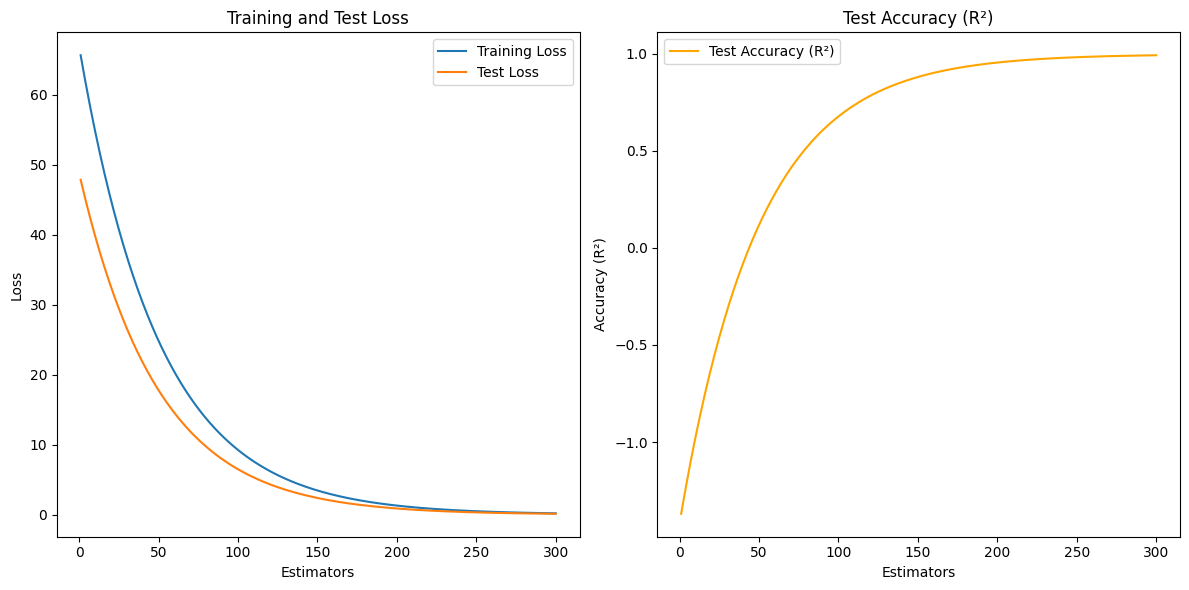

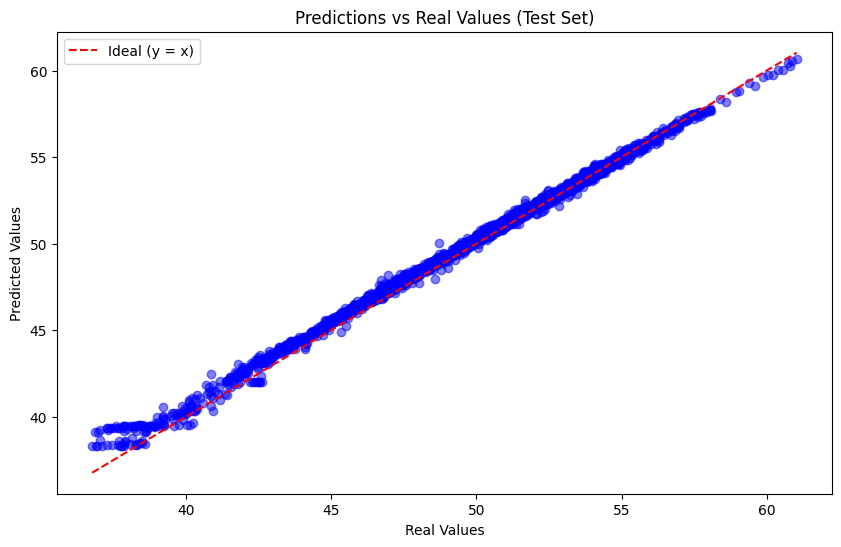

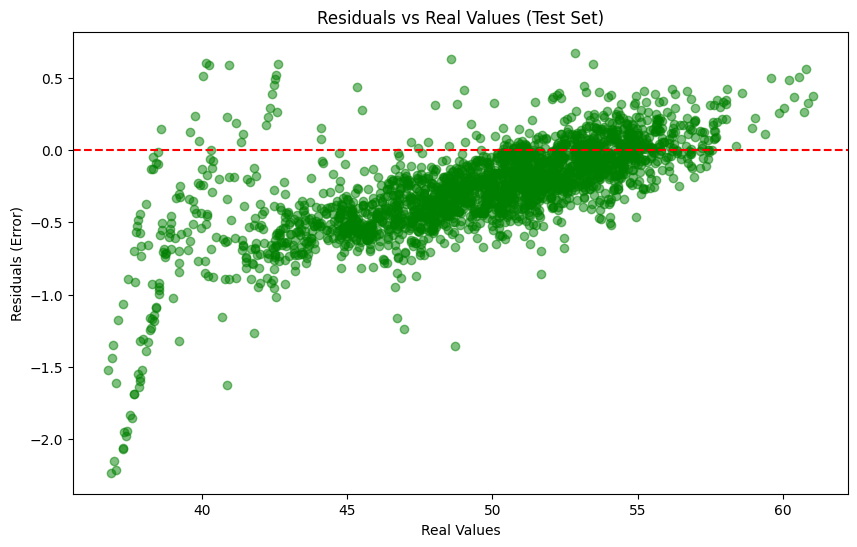

In [128]:
estimators = 300

# Entrenar y obtener métricas
train_losses, test_losses, test_accuracies = train_and_evaluate_xgboost(model, X_train, y_train, X_test, y_test, max_estimators=estimators)

# Graficar métricas
plot_training_metrics(train_losses, test_losses, test_accuracies, max_estimators=estimators)

# Hacer predicciones en el conjunto de prueba
y_test_pred = model.predict(X_test)

# Graficar predicciones vs reales
plot_test_predictions(y_test, y_test_pred)

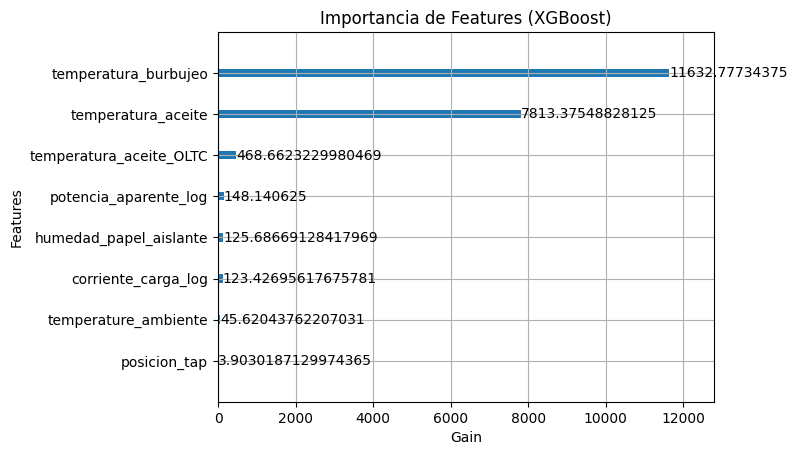

In [70]:
xgb.plot_importance(model, importance_type='gain', xlabel='Gain')
plt.title("Importancia de Features (XGBoost)")
plt.show()

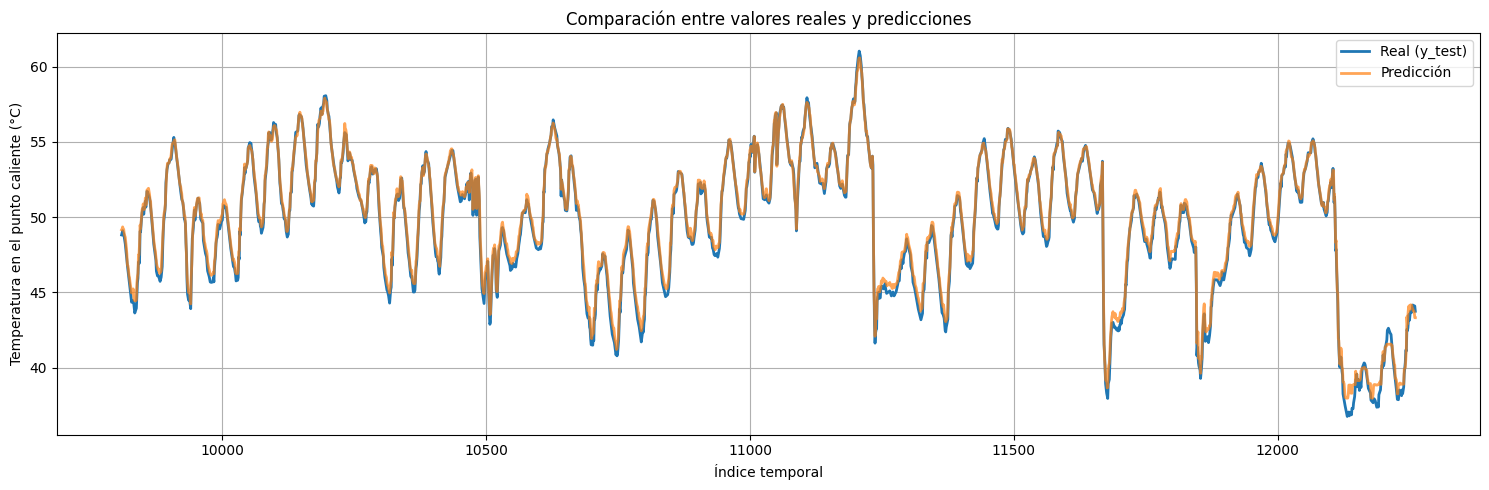

In [74]:
# Gráfico de series temporales reales vs predichas
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label="Real (y_test)", linewidth=2)
plt.plot(y_test.index, y_test_pred, label="Predicción", linewidth=2, alpha=0.7)
plt.title("Comparación entre valores reales y predicciones")
plt.xlabel("Índice temporal")
plt.ylabel("Temperatura en el punto caliente (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()